In [5]:
import numpy as np
import pandas as pd
from math import isnan
import choropie.ChoroPie as cp
from mpl_toolkits.basemap import Basemap

import os

In [6]:
# from mpl_toolkits.basemap import Basemap
# import matplotlib.pyplot as plt
# # setup Lambert Conformal basemap.
# # set resolution=None to skip processing of boundary datasets.
# m = Basemap(width=12000000,height=9000000,projection='lcc',
#             resolution=None,lat_1=45.,lat_2=55,lat_0=50,lon_0=-107.)
# m.bluemarble()
# plt.show()

In [7]:


dict_states = {
    'AK': 'Alaska',
    'AL': 'Alabama',
    'AR': 'Arkansas',
    'AS': 'American Samoa',
    'AZ': 'Arizona',
    'CA': 'California',
    'CO': 'Colorado',
    'CT': 'Connecticut',
    'DC': 'District of Columbia',
    'DE': 'Delaware',
    'FL': 'Florida',
    'GA': 'Georgia',
    'GU': 'Guam',
    'HI': 'Hawaii',
    'IA': 'Iowa',
    'ID': 'Idaho',
    'IL': 'Illinois',
    'IN': 'Indiana',
    'KS': 'Kansas',
    'KY': 'Kentucky',
    'LA': 'Louisiana',
    'MA': 'Massachusetts',
    'MD': 'Maryland',
    'ME': 'Maine',
    'MI': 'Michigan',
    'MN': 'Minnesota',
    'MO': 'Missouri',
    'MP': 'Northern Mariana Islands',
    'MS': 'Mississippi',
    'MT': 'Montana',
    'NA': 'National',
    'NC': 'North Carolina',
    'ND': 'North Dakota',
    'NE': 'Nebraska',
    'NH': 'New Hampshire',
    'NJ': 'New Jersey',
    'NM': 'New Mexico',
    'NV': 'Nevada',
    'NY': 'New York',
    'OH': 'Ohio',
    'OK': 'Oklahoma',
    'OR': 'Oregon',
    'PA': 'Pennsylvania',
    'PR': 'Puerto Rico',
    'RI': 'Rhode Island',
    'SC': 'South Carolina',
    'SD': 'South Dakota',
    'TN': 'Tennessee',
    'TX': 'Texas',
    'UT': 'Utah',
    'VA': 'Virginia',
    'VI': 'Virgin Islands',
    'VT': 'Vermont',
    'WA': 'Washington',
    'WI': 'Wisconsin',
    'WV': 'West Virginia',
    'WY': 'Wyoming'
    }

# dict_df = dict(pd.read_csv('Data/county_facts_dictionary.csv').get_values())

df = pd.read_csv('Data/county_facts_dictionary.csv')

dict_df = dict(df.values)
df_facts = pd.read_csv('Data/county_facts.csv')

column_lst = []
for column in df_facts.columns:
    if column in dict_df:
        column_lst.append(dict_df[column])
    else:
        column_lst.append(column)


df_facts.columns = column_lst

df_facts.dropna(inplace=True)

df_facts['area_name'] = df_facts['area_name'].apply(lambda x: x.replace(' County', ''))

df_facts.columns = ['county' if name == 'area_name' else name for name in df_facts.columns]

df_facts['state'] = df_facts['state_abbreviation'].apply(lambda x: dict_states[x])

df_facts.set_index(['state', 'fips'], inplace=True)




No Pies Plotted!
exception:  'ChoroPie' object has no attribute 'mpl_paths'
No Polygons Plotted!
exception:  'ChoroPie' object has no attribute 'mpl_polygons'


TypeError: '<=' not supported between instances of 'list' and 'int'

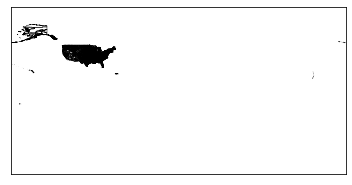

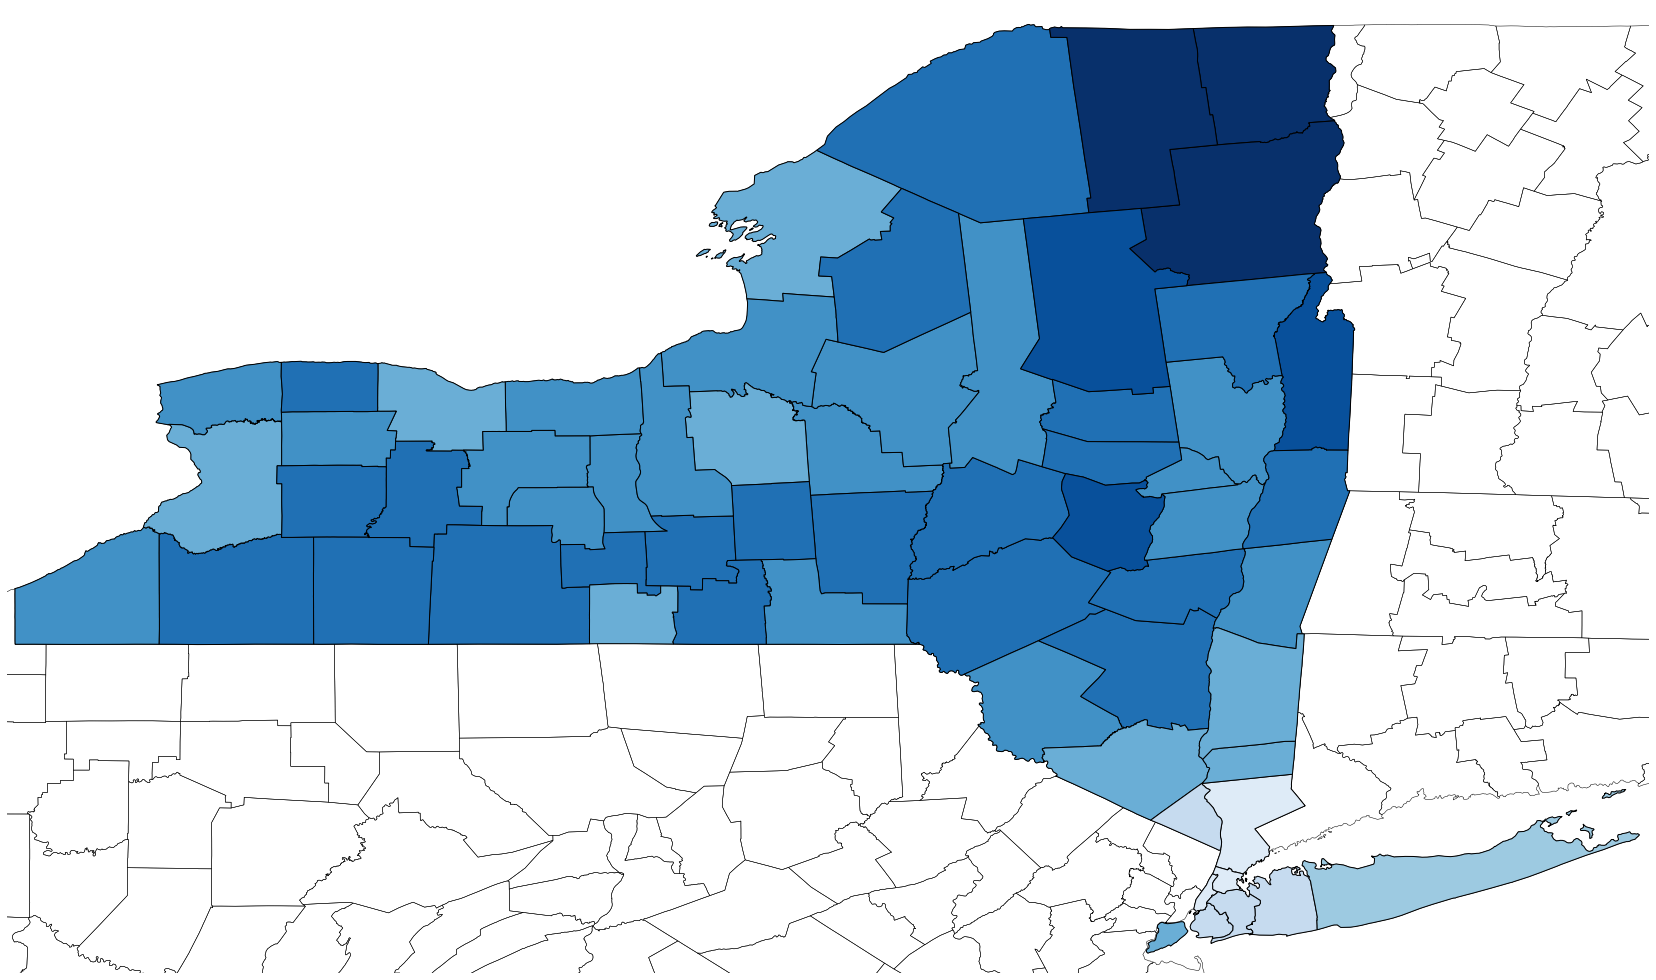

In [8]:
###

df_primary = pd.read_csv('Data/primary_results.csv')

df_votes = df_primary.pivot_table(index=['state', 'fips'], columns=['party', 'candidate'], values=['fraction_votes', 'votes'], aggfunc=sum)

df_votes.columns = df_votes.columns.droplevel(1)

###

state = 'New York'

df_facts_state = df_facts.loc[state]
df_votes_state = df_votes.loc[state]

df_votes_state.index = df_votes_state.index.astype(int)

# df_state = df_votes.groupby('state').sum()

###

df_main_state = pd.concat([df_votes_state, df_facts_state], axis=1)
df_main_state.index = df_main_state.index.astype('str')

# df_main.drop(df_main.columns[:2], axis=1, inplace=True)

df_percs = df_main_state[[col for col in df_main_state.columns if 'alone' in col or 'Latino' in col][1:]]

df_percs.columns = ['Black', 'Native American', 'Asian', 'Ocean Pacific', 'Hispanic', 'White']

# df_percents['sum'] = df_percents.sum(axis=1)

series_percs = df_percs.stack()

###

candidate = 'Bernie Sanders'
cmap = 'Blues'

series_size = df_votes.loc[state, 'votes'].sum(axis=1)
series_size.index = series_size.index.astype(int)
series_size.index = series_size.index.astype(str)

###
shp_file = 'Shapefiles/cb_2016_us_county_500k'
shp_lst = cp.get_shp_attributes(shp_file)

key = cp.find_shp_key(df_main_state.index, shp_lst)
###

basemap = dict(
    basemap_kwargs=dict(llcrnrlon=-79.80,llcrnrlat=40.40,urcrnrlon=-71.81,urcrnrlat=45.1, lat_0=043.2994, lon_0=74.2179,
                 resolution='i', projection='tmerc', epsg=4269
    ),
    shp_file=shp_file,
    shp_key=key,
    figsize=(24,24))

choro = dict(
    num_colors=8,
    # zero_base=True,
    cmap=cmap,
    color_data=df_main_state[('fraction_votes', candidate)]
    )

pie= dict(
    pie_data=series_percs,
    size_data=series_size,
    scale_factor_size = 1/2,
    pie_dict={'Asian': 'cyan', 'Black': 'blue', 'Hispanic': 'green',
              'Native American': 'purple', 'Ocean Pacific': 'red', 'White': '0.75'},
    )

test = cp.ChoroPie(**basemap)

test.clear_elements()

# %timeit ChoroPie(**basemap)

test.choro_plot(**choro)
test.pie_plot(**pie)

test.ax.set_title('2016 Primary Results: Bernie Sanders', fontsize=30, fontweight='bold')
test.insert_colorbar(colorbar_title='Map: {} Votes'.format(candidate), colorbar_loc_kwargs=dict(location='bottom'))
test.insert_pie_legend(legend_loc='upper left', pie_legend_kwargs=dict(title='Pies: Racial Breakdown in Each County'))
test.ax_colorbar.set_xticklabels([str('{:.0f}'.format(float(i.get_text()) * 100)) + '%' for i in test.ax_colorbar.get_xmajorticklabels()])

###
df_state = df_primary[df_primary['state'] == 'New York']
queery = df_state.set_index('county').loc[['Queens', 'Bronx', 'Brooklyn', 'Manhattan', 'Staten Island', 'Rockland', 'Westchester', 'Orange', 'Putnam']]['fips'].unique().astype(int)
# #

test.fig
####

test.fig.savefig('Outputs/Pie_Plots/NYS.png', bbox_inches='tight')

test.zoom_to_area([str(num) for num in queery])

test.fig.savefig('Outputs/Pie_Plots/NYC_and_North_{}.png'.format(candidate.split()[-1]), bbox_inches='tight')

test.zoom_home()